0. Imports

In [56]:
# data processing
import numpy as np

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from svm_utils import *
from data_configuration import *


Loading the CSV dataset

In [74]:
dataset = getCSVData(Location.company_bankruptcy_data_raw)
dataset.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


Show the relationship between all pairs of columns in a dataset

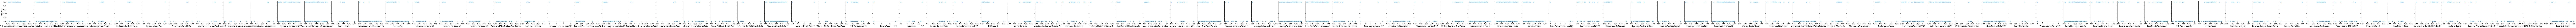

In [59]:
data_cols = [col_name for col_name in dataset.columns if col_name != ProcessConfig.company_bankruptcy_label]
sns.pairplot(data=dataset, y_vars=[ProcessConfig.company_bankruptcy_label], x_vars=data_cols)

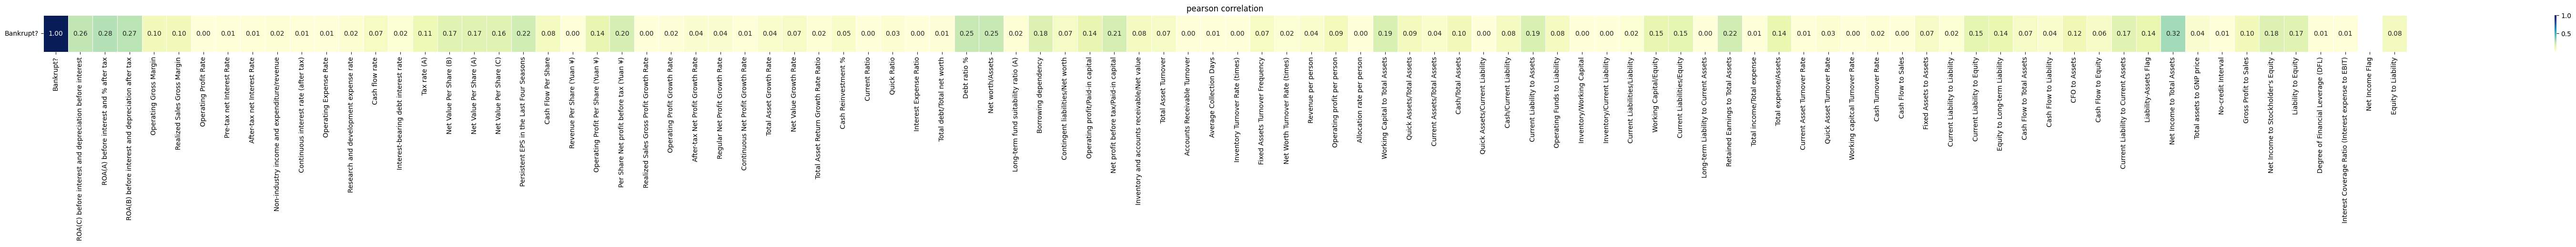

In [60]:
corr = corr_matrix(dataset, method="pearson", negative=False, lst_filters=[ProcessConfig.company_bankruptcy_label], figsize=(80,1))

<Axes: >

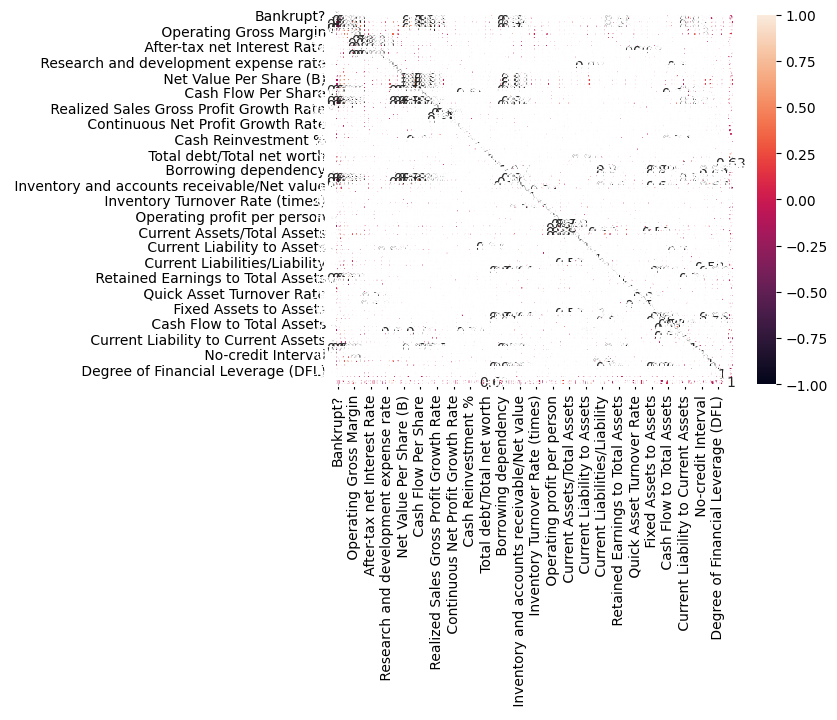

In [75]:
sns.heatmap(dataset.corr(), annot=True)

After processed the data, get the train and test

In [61]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.company_bankruptcy_data_process)


In [62]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)


In [63]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)

1. Initializes an H2O cluster and converts the training data to an H2OFrame

In [64]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-25199 (build 11.0.12+7, mixed mode)
  Starting server from C:\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmp13tcy3zt
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmp13tcy3zt\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmp13tcy3zt\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,15 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_Administrator_m08n9k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.945 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [65]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [66]:
# Specify target variable and predictor variables
x = train.drop(ProcessConfig.company_bankruptcy_label, axis=1).columns
y = ProcessConfig.company_bankruptcy_label

Run H2O AutoML to automatically select, train and optimize SVM model

In [67]:
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
19:12:53.852: AutoML: XGBoost is not available; skipping it.
19:12:54.56: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

███
19:13:04.570: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

█████████████████████████
19:15:06.87: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

███████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20230227_191253


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    367                367                         195490                 8            15           14.6703       17            76            37.455

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.003541369212752763
RMSE: 0.05950940440596564
MAE: 0.02874520180999616
RMSLE: NaN
Mean Residual Deviance: 0.003541369212752763

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.00866983079499598
RMSE: 0.09311192616950839
MAE: 0.046675943919386544
RMSLE: NaN
Mean Residual Deviance: 0.00866983079499598

Cross-Validation Metrics Summary: 
                        mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0466758   0.00135052  0.0463903     0.0490653     0.0460405     0.0460475     0.0458354
mean_residual_deviance  0.00866965  0.00222776  0.00708887    0.0122885     0.00857876    0.00878069    0.00661143
mse                     0.00866965  0.00222776  0.00708887    0.0122885     0.00857876    0.00878069    0.00661143
r2                      0.991358    0.00201083  0.992499      0.988026      0.991761      0.99125       0.993254
residual_deviance       0.00866965  0.00222776  0.00708887    0.0122885     0.00857876    0.00878069    0.00661143
rmse                    0.0925373   0.0115377   0.0841954     0.110853      0.0926216     0.0937054     0.0813107
rmsle                   nan         0           nan           nan           nan           nan           nan

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse         training_mae          training_deviance
---  -------------------  ----------------  -----------------  --------------------  --------------------  ---------------------
     2023-02-27 19:14:46  1 min 41.849 sec  0.0                0.9999999995359892    0.716334120015151     0.9999999990719785
     2023-02-27 19:14:46  1 min 42.345 sec  5.0                0.6132733696343354    0.43145447322667274   0.3761042259026522
     2023-02-27 19:14:47  1 min 42.688 sec  10.0               0.38733483447044087   0.26474140699784293   0.15002827399424384
     2023-02-27 19:14:47  1 min 43.035 sec  15.0               0.2607894180129817    0.16756231742849403   0.06801112054754971
     2023-02-27 19:14:47  1 min 43.340 sec  20.0               0.19226641555368482   0.11300186248153081   0.036966374549862215
     2023-02-27 19:14:48  1 min 43.655 sec  25.0               0.1587717021430042    0.08442192754750043   0.025208453401386843
     2023-02-27 19:14:48  1 min 44.015 sec  30.0               0.1394614255495959    0.06886417480944522   0.01944948921632548
     2023-02-27 19:14:48  1 min 44.341 sec  35.0               0.12893755916137567   0.06043354479823513   0.01662489416249325
     2023-02-27 19:14:49  1 min 44.695 sec  40.0               0.12190550524408748   0.05574421475875605   0.01486095220881624
     2023-02-27 19:14:49  1 min 45.033 sec  45.0               0.11700548752587395   0.05289134292815433   0.013690284111167444
---  ---                  ---               ---                ---                   ---                   ---
     2023-02-27 19:15:03  1 min 59.128 sec  325.0              0.062443966624936044  0.029989222268351445  0.0038992489678561265
     2023-02-27 19:15:03  1 min 59.379 sec  330.0              0.06213013342085535   0.029807529918676388  0.003860153478893287
     2023-02-27 19:15:04  

In [68]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                mse            rmse           mae    rmsle    mean_residual_deviance
GBM_1_AutoML_1_20230227_191253  0.00866983        0.0931119     0.0466759      nan               0.00866983
GLM_1_AutoML_1_20230227_191253  2.79679e+10  167236          1627.83           nan               2.79679e+10
[2 rows x 6 columns]



In [69]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = [col_name for col_name in dataset.columns if col_name != ProcessConfig.company_bankruptcy_label]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [70]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [71]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [   0    7   13   16   22   40   55   57   64   71   88   94  109  110
  121  122  123  124  145  149  157  176  180  184  187  201  202  204
  209  233  237  279  284  313  329  347  371  388  390  394  395  405
  451  453  458  465  468  504  505  544  550  551  552  559  564  566
  582  590  592  593  595  601  614  617  621  627  639  651  657  670
  689  690  691  698  701  707  708  717  721  734  738  744  750  755
  787  789  795  808  821  833  844  852  857  859  861  866  883  907
  918  942  969  971  972  979  988  989  993  994  998 1018 1044 1047
 1060 1065 1074 1076 1077 1080 1085 1086 1102 1104 1117 1124 1136 1143
 1146 1151 1155 1157 1166 1184 1196 1210 1214 1227 1250 1254 1258 1272
 1292 1294 1305 1312 1319 1337 1345 1363 1371 1393 1407 1423 1448 1487
 1496 1507 1508 1530 1533 1549 1555 1585 1591 1605 1610 1612 1628 1636
 1637 1651 1656 1657 1660 1663 1686 1688 1691 1695 1718 1726 1735 1741
 1745 1751 1754 1761 1771 17

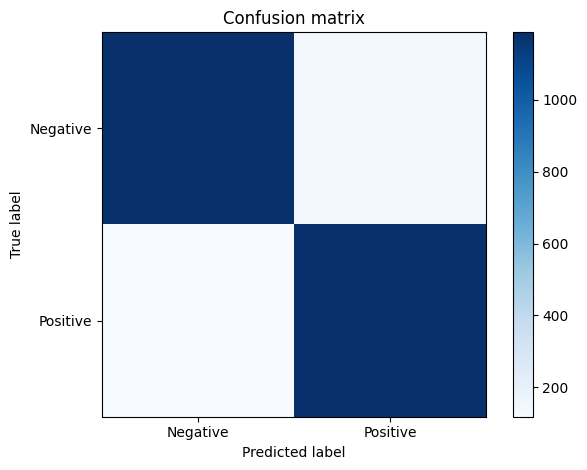

In [72]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

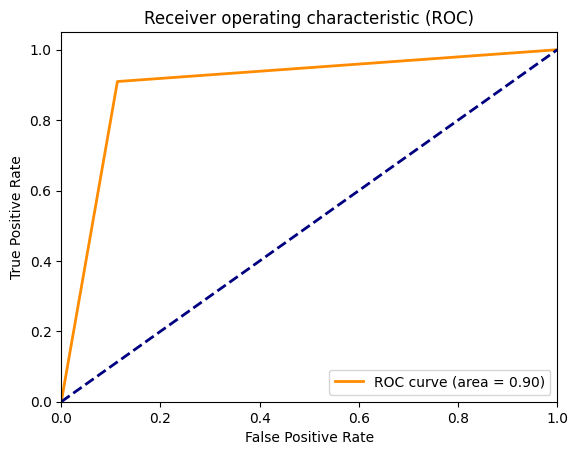

In [73]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()